# This notebook aims to fill the gaps from the DOSE data set

It uses the UN WDI, and the complementary set of countries from DOSE. 

In [1]:
import json
import io
import re
import itertools as iter
import numpy as np
import os
from random import sample

# data

import pandas as pd
import ibis as ib
from ibis import _
ib.options.interactive = True

from parameters import year,missing_frac



In [2]:
# The duckdb/ibis way require to either create an in-memory database at the moment of execution of the notebook, or saving the database in a file. 
conn = ib.connect('duckdb://')
conn.list_tables() # empty

[]

In [3]:
# loading the spatial extension.
# res = conn.raw_sql("install spatial; load spatial")
# print(res)

In [4]:
### A year of interest:


### Enter A YEAR OF INTEREST IN parameters.py

Reading in data

With **ibis**

In [5]:
dose = conn.read_csv("../datasets/DOSE/DOSE_V2.csv",table_name="dose",all_varchar = True)

In [6]:
wdi = conn.read_csv("../datasets/WDI_CSV_2024_06_28/WDICSV.csv",table_name="wdi")

In [7]:
# load extension first
res = conn.raw_sql("""INSTALL spatial;LOAD spatial;""")
res

In [8]:
# the merged file
#local path with folder where the downloaded shapefiles are stored 
#(both GADM and the custom one)
gadm_path = '../datasets/DOSE/DOSE_replication_files/DOSE_replication_files/Data/spatial data/' # ../../../../../
# Read shapefiles
file_name = "gadm36_1"
# gpd.list_layers(gadm_path+file_name+".gpkg")

# gadm = gpd.read_file(gadm_path+"gadm36_levels_shp/" + file_name+".shp")
# has to be downloaded from https://gadm.org/download_world36.html; follow instructions in readme


In [9]:
# ../datasets/boundaries/GADM/gadm_410.gpkg

conn.raw_sql(f"""CREATE OR REPLACE TABLE boundaries AS SELECT * FROM st_read('{gadm_path+"gadm36_levels_shp/" + file_name+".shp"}');""") 

In [10]:
boundaries = conn.table("boundaries")

In [11]:
boundaries = boundaries.rename("snake_case")

In [12]:
boundary_countries = conn.sql("Select distinct(gid_0) from boundaries;").to_pandas().iloc[:,0].to_list()
print(len(boundary_countries))
sample(boundary_countries,k=5)

228


['AGO',
 'ARM',
 'AUS',
 'BRN',
 'COG',
 'CPV',
 'CRI',
 'CYM',
 'ESP',
 'FIN',
 'GGY',
 'IMN',
 'IRL',
 'ISR',
 'JAM',
 'KGZ',
 'KHM',
 'KNA',
 'LIE',
 'MAR',
 'MWI',
 'MYT',
 'NCL',
 'NPL',
 'REU',
 'RWA',
 'SEN',
 'SWE',
 'TCD',
 'TJK',
 'TWN',
 'UKR',
 'URY',
 'USA',
 'VGB',
 'VIR',
 'BES',
 'BOL',
 'CMR',
 'CUB',
 'DMA',
 'ECU',
 'FRA',
 'GNB',
 'GUY',
 'IND',
 'LUX',
 'MKD',
 'MNG',
 'MNP',
 'MUS',
 'PER',
 'PHL',
 'SAU',
 'TCA',
 'TGO',
 'VUT',
 'YEM',
 'ALA',
 'AZE',
 'BHS',
 'CIV',
 'COL',
 'CZE',
 'DJI',
 'FJI',
 'GAB',
 'GLP',
 'ITA',
 'KWT',
 'LBN',
 'LCA',
 'MAC',
 'MLT',
 'MRT',
 'MSR',
 'MTQ',
 'NGA',
 'PRI',
 'SUR',
 'SVK',
 'THA',
 'TTO',
 'TZA',
 'UGA',
 'AFG',
 'ALB',
 'ATG',
 'BGD',
 'BRB',
 'CAN',
 'COD',
 'DZA',
 'ESH',
 'GHA',
 'GUF',
 'HRV',
 'ISL',
 'JOR',
 'KAZ',
 'KEN',
 'KOR',
 'LBR',
 'LKA',
 'MDG',
 'NAM',
 'OMN',
 'PAN',
 'PLW',
 'PNG',
 'PRK',
 'PSE',
 'RUS',
 'SPM',
 'SSD',
 'TUR',
 'VEN',
 'ZAF',
 'ARE',
 'ARG',
 'ATF',
 'BLR',
 'CAF',
 'CHL',
 'DNK',


In [13]:
# how to name tables properly ?
conn.list_tables()

['boundaries', 'dose', 'wdi']

### Inspection

In [14]:
dose.head()

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ country ┃ region ┃ GID_0  ┃ GID_1   ┃ year   ┃ grp_lcu     ┃ pop    ┃ grp_pc_lcu ┃ ag_grp_pc_lcu ┃ man_grp_pc_lcu ┃ serv_grp_pc_lcu ┃ grp_pc_usd  ┃ ag_grp_pc_usd ┃ man_grp_pc_usd ┃ serv_grp_pc_usd ┃ grp_pc_lcu_2015 ┃ ag_grp_pc_lcu_2015 ┃ man_grp_pc_lcu_2015 ┃ serv_grp_pc_lcu_2015 ┃ grp_pc_usd_2015 ┃ ag_grp_pc_usd_2015 ┃ man_grp_pc_usd_2015 ┃ serv_grp_pc_usd_2015 ┃ grp_pc_lcu2015_usd ┃ ag_grp_pc_lcu2015_usd ┃ man_grp_pc_lcu2015_usd ┃ serv_grp_pc_lcu2015_usd ┃ cpi_2015    ┃ deflator_2015 ┃ fx          ┃ PPP         ┃ StructChange ┃ version ┃ T_a         ┃ P_a         ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ string  │ string │ string │ string  │ string │ string      │ string │ string     │ string        │ string         │ string          │ string      │ string        │ string         │ string          │ string          │ string             │ string              │ string               │ string          │ string             │ string              │ string               │ string             │ string                │ string                 │ string                  │ string      │ string        │ string      │ string      │ string       │ string  │ string      │ string      │
├─────────┼────────┼────────┼─────────┼────────┼─────────────┼────────┼────────────┼───────────────┼────────────────┼─────────────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────┼───────────────────────┼────────────────────────┼─────────────────────────┼─────────────┼───────────────┼─────────────┼─────────────┼──────────────┼─────────┼─────────────┼─────────────┤
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2010   │ 49416066001 │ 151375 │ 326448     │ NULL          │ NULL           │ NULL            │ 3140.842514 │ NULL          │ NULL           │ NULL            │ 345645.9835     │ NULL               │ NULL                │ NULL                 │ 3419.068968     │ NULL               │ NULL                │ NULL                 │ 2744.075141        │ NULL                  │ NULL                   │ NULL                    │ 104.7429508 │ 94.44576693   │ 103.9364434 │ 44.19621436 │ 0            │ 2       │ 13.12376773 │ 1573.116224 │
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2011   │ 52603911678 │ 148160 │ 355048     │ NULL          │ NULL           │ NULL            │ 3518.986662 │ NULL          │ NULL           │ NULL            │ 367423.0111     │ NULL               │ NULL                │ NULL                 │ 3752.327886     │ NULL               │ NULL                │ NULL                 │ 2916.962438        │ NULL                  │ NULL                   │ NULL                    │ 113.2074664 │ 96.63194446   │ 100.8949547 │ 43.85768488 │ 0            │ 2     

In [15]:
dose.filter(_.country=="Laos").head(3)

┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ country ┃ region  ┃ GID_0  ┃ GID_1    ┃ year   ┃ grp_lcu  ┃ pop    ┃ grp_pc_lcu  ┃ ag_grp_pc_lcu ┃ man_grp_pc_lcu ┃ serv_grp_pc_lcu ┃ grp_pc_usd  ┃ ag_grp_pc_usd ┃ man_grp_pc_usd ┃ serv_grp_pc_usd ┃ grp_pc_lcu_2015 ┃ ag_grp_pc_lcu_2015 ┃ man_grp_pc_lcu_2015 ┃ serv_grp_pc_lcu_2015 ┃ grp_pc_usd_2015 ┃ ag_grp_pc_usd_2015 ┃ man_grp_pc_usd_2015 ┃ serv_grp_pc_usd_2015 ┃ grp_pc_lcu2015_usd ┃ ag_grp_pc_lcu2015_usd ┃ man_grp_pc_lcu2015_usd ┃ serv_grp_pc_lcu2015_usd ┃ cpi_2015    ┃ deflator_2015 ┃ fx          ┃ PPP         ┃ StructChange ┃ version ┃ T_a         ┃ P_a         ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ string  │ string  │ string │ string   │ string │ string   │ string │ string      │ string        │ string         │ string          │ string      │ string        │ string         │ string          │ string          │ string             │ string              │ string               │ string          │ string             │ string              │ string               │ string             │ string                │ string                 │ string                  │ string      │ string        │ string      │ string      │ string       │ string  │ string      │ string      │
├─────────┼─────────┼────────┼──────────┼────────┼──────────┼────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────┼───────────────────────┼────────────────────────┼─────────────────────────┼─────────────┼───────────────┼─────────────┼─────────────┼──────────────┼─────────┼─────────────┼─────────────┤
│ Laos    │ Saravan │ LAO    │ LAO.11_1 │ 1995   │ NULL     │ NULL   │ 135973.9777 │ NULL          │ NULL           │ NULL            │ 168.9768454 │ NULL          │ NULL           │ NULL            │ 2876195.764     │ NULL               │ NULL                │ NULL                 │ 246.1497107     │ NULL               │ NULL                │ NULL                 │ NULL               │ NULL                  │ NULL                   │ NULL                    │ 12.22438449 │ 4.727563381   │ 804.69      │ 213.4563692 │ 0            │ 1       │ 23.97160813 │ 1676.981038 │
│ Laos    │ Saravan │ LAO    │ LAO.11_1 │ 2006   │ 1.45E+12 │ 332037 │ 4354935.737 │ 2611154.78    │ 728834.4369    │ 1014947.129     │ 428.6379737 │ 257.0049621   │ 71.73610244    │ 99.89696911     │ 7388921.332     │ 4430287.476        │ 1236596.966         │ 1722037.923          │ 497.9215242     │ 298.5463498        │ 83.33127642         │ 116.0439676          │ NULL               │ NULL                  │ NULL                   │ NULL                    │ 23.949398   │ 58.93872112   │ 10159.93917 │ 2118.886332 │ 1            │ 1     

In [16]:
wdi.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ Country Name                ┃ Country Code ┃ Indicator Name                                                                   ┃ Indicator Code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000      ┃ 2001      ┃ 2002      ┃ 2003      ┃ 2004      ┃ 2005      ┃ 2006      ┃ 2007      ┃ 2008      ┃ 2009      ┃ 2010      ┃ 2011      ┃ 2012      ┃ 2013      ┃ 2014      ┃ 2015      ┃ 2016      ┃ 2017      ┃ 2018      ┃ 2019      ┃ 2020      ┃ 2021      ┃ 2022      ┃ 2023    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ string                      │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64 │
├─────────────────────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────

#### Changing column names for easier manipulation

In [17]:
# cool function from ibis, no need for the previous cells, althought the python dict comprehension method is cool as well.
wdi = wdi.rename("snake_case")
dose = dose.rename("snake_case")

In [18]:
# some columns
wdi.columns[0:5]

['country_name', 'country_code', 'indicator_name', 'indicator_code', '1960']

In [19]:
# some columns
dose.columns[0:5]

['country', 'region', 'gid_0', 'gid_1', 'year']

In [20]:
wdi.filter(_.country_code=="VEN").head(3)

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ country_name  ┃ country_code ┃ indicator_name                                                                   ┃ indicator_code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000    ┃ 2001    ┃ 2002    ┃ 2003    ┃ 2004    ┃ 2005    ┃ 2006    ┃ 2007    ┃ 2008    ┃ 2009    ┃ 2010    ┃ 2011    ┃ 2012    ┃ 2013    ┃ 2014    ┃ 2015    ┃ 2016    ┃ 2017    ┃ 2018    ┃ 2019    ┃ 2020    ┃ 2021    ┃ 2022    ┃ 2023    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ string        │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │
├───────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ Venezuela, RB │ VEN          │ Access to clean fuels and technologies for cooking (% of population)             │ EG.C

#### Country codes in the data sets

In [21]:
wdi_countries = np.unique(wdi.country_code.__array__()).tolist()

In [22]:
len(wdi_countries)

266

In [23]:
dose_countries = dose.filter(_.year==str(year)).gid_0.to_pandas().unique().tolist()
dose_countries

['ALB',
 'ARG',
 'AUS',
 'AUT',
 'AZE',
 'BHS',
 'BLR',
 'BEL',
 'BOL',
 'BIH',
 'BRA',
 'BGR',
 'CAN',
 'CHL',
 'CHN',
 'COL',
 'HRV',
 'CZE',
 'DNK',
 'ECU',
 'EGY',
 'EST',
 'FIN',
 'FRA',
 'GEO',
 'DEU',
 'GRC',
 'HUN',
 'IND',
 'IDN',
 'IRN',
 'IRL',
 'ITA',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'LVA',
 'LTU',
 'MKD',
 'MYS',
 'MEX',
 'MNG',
 'MAR',
 'MOZ',
 'NLD',
 'ANT',
 'NZL',
 'NGA',
 'NOR',
 'PAN',
 'PRY',
 'PHL',
 'POL',
 'PRT',
 'ROU',
 'RUS',
 'SRB',
 'SVK',
 'SVN',
 'ZAF',
 'KOR',
 'ESP',
 'LKA',
 'SWE',
 'CHE',
 'TZA',
 'THA',
 'TUR',
 'GBR',
 'USA',
 'UKR',
 'UZB',
 'VNM']

In [24]:
wdi.filter(_.country_code=="VEN")

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ country_name  ┃ country_code ┃ indicator_name                                                                   ┃ indicator_code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992      ┃ 1993      ┃ 1994      ┃ 1995      ┃ 1996      ┃ 1997      ┃ 1998     ┃ 1999      ┃ 2000    ┃ 2001    ┃ 2002    ┃ 2003    ┃ 2004    ┃ 2005    ┃ 2006    ┃ 2007    ┃ 2008    ┃ 2009    ┃ 2010    ┃ 2011    ┃ 2012    ┃ 2013    ┃ 2014    ┃ 2015    ┃ 2016    ┃ 2017    ┃ 2018    ┃ 2019    ┃ 2020    ┃ 2021    ┃ 2022    ┃ 2023    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ string        │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64  │ float64   │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │
├───────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼──────────┼───────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ Venezuela, RB │ VEN          │ Access to cl

## Country representation

In [26]:
# in dose, there is an uneven representation of regions from one year to another.
# using boundaries as the baseline to how many sub national entities should be in a country 

boundary_sizes = boundaries.gid_0.value_counts().execute().set_index("gid_0")

In [27]:
dose_representation = dose.filter(_.year==str(year)).gid_0.value_counts().execute().set_index("gid_0")

In [28]:
dose_complete = (boundary_sizes
    .merge(dose_representation,how="left",suffixes=["_bound","_dose"],on="gid_0")
    .assign(repr_frac=lambda x: x.gid_0_count_dose/x.gid_0_count_bound)
    .fillna(0)
    .reset_index(drop=False,inplace=False))


In [29]:
missing_frac = 0.5

missing_countries_year = conn.sql(f"""select gid_0 from dose_complete where repr_frac<{missing_frac};""").to_pandas().gid_0.to_list()
len(missing_countries_year)

160

## Missing regions
Determining the missing regions from DOSE using the 3 letter country codes compared to the equivalent variable in WDI indicators

In [30]:
missing_regions = [x for x in wdi_countries if x not in dose_countries and x in boundary_countries]

In [31]:
len(missing_regions)

133

### WDI of interest

getting the variables of interest from the WDI index for the missing countries in the DOSE data set.

In [33]:
# should not be null
wdi.filter(_.country_code.isin(missing_countries_year)).order_by("country_name").head(3)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ country_name ┃ country_code ┃ indicator_name                                                                   ┃ indicator_code ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000    ┃ 2001    ┃ 2002         ┃ 2003         ┃ 2004         ┃ 2005         ┃ 2006         ┃ 2007         ┃ 2008         ┃ 2009         ┃ 2010         ┃ 2011         ┃ 2012         ┃ 2013         ┃ 2014         ┃ 2015         ┃ 2016         ┃ 2017         ┃ 2018         ┃ 2019         ┃ 2020         ┃ 2021         ┃ 2022         ┃ 2023    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ string       │ string       │ string                                                                           │ string         │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64 │
├──────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─

### Indicators 

#### WDI

More on the indicators considered from the wdi website : https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators.


##### Agriculture, forestry, and fishing, value added (ppercentage of GDP)

Agriculture corresponds to ISIC divisions 1-5 and includes forestry, hunting, and fishing, as well as cultivation of crops and livestock production. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

##### Industry (including construction), value added (% of GDP)

Industry corresponds to ISIC divisions 10-45 and includes manufacturing (ISIC divisions 15-37). It comprises value added in mining, manufacturing (also reported as a separate subgroup), construction, electricity, water, and gas. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

##### Manufacturing, value added (% of GDP)

Manufacturing refers to industries belonging to ISIC divisions 15-37. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

##### Services, value added (% of GDP)

Services correspond to ISIC divisions 50-99 and they include value added in wholesale and retail trade (including hotels and restaurants), transport, and government, financial, professional, and personal services such as education, health care, and real estate services. Also included are imputed bank service charges, import duties, and any statistical discrepancies noted by national compilers as well as discrepancies arising from rescaling. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The industrial origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3 or 4.

#### <font color='green'>Manufacturing is included in construction !!!</font>


### DOSE

<!-- ![Dose ISIC classification](../img/dose_isic_table.png) -->
<center>
<img src="../img/dose_isic_table.png" width="50%">
</center>

<!-- # from IPython.display import Image
# Image(filename="../img/dose_isic_table.png", width=700) -->

### Remarks

* The ISIC divisions 46-49 (inclusive) seem not to be covered in WDI, the are in the *services* category in DOSE.
* In order to match with DOSE, the *industry* variable from WDI (which includes *manufacturing*) is renamed into *manufacturing* later on.

In [34]:
indicators = wdi.indicator_name.to_pandas().unique().tolist()
indicators[0:9]

['Access to clean fuels and technologies for cooking (% of population)',
 'Access to clean fuels and technologies for cooking, rural (% of rural population)',
 'Access to clean fuels and technologies for cooking, urban (% of urban population)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)']

In [35]:
# subsetting the variables with relevant currency as constant 2015 values
# [x for x in indicators if re.search(string=x,pattern="constant 2015 US\\$")]
# [x for x in indicators if re.search(string=x,pattern="\\% of GDP")]

In [36]:
# manually getting the useful variables and storing in a dict with simplified names.
indicators_of_intereset_perc = {
    "country" : "country_name",
    "grp_usd_2015" : 'GDP (constant 2015 US$)',
    "gdp_cap" : "GDP per capita (constant 2015 US$)",
    "industry_perc" : "Industry (including construction), value added (% of GDP)",
    "services_perc" : "Services, value added (% of GDP)",
    "agriculture_perc" : "Agriculture, forestry, and fishing, value added (% of GDP)",
}

indicators_of_intereset_usd_2015 = {
    "country" : "country_name",
    "grp_usd_2015" : 'GDP (constant 2015 US$)',
    "gdp_cap" : "GDP per capita (constant 2015 US$)",
    "industry_usd_2015" : "Industry (including construction), value added (constant 2015 US$)",
    "services_usd_2015" : "Services, value added (constant 2015 US$)",
    "agriculture_usd_2015" : "Agriculture, forestry, and fishing, value added (constant 2015 US$)",
    
}


In [37]:
# select here which dict of indicators to use : the _usd_2015 is considered only at this point
indicators_of_intereset = indicators_of_intereset_usd_2015

In [38]:
if str(year) not in wdi.columns:
    raise ValueError("No such year ({}) in WDI data".format(year))

In [39]:
wdi_cols = ["country_name","country_code","indicator_name","indicator_code",str(year)]

# keeping indicators of interest and countries of interest
wdi_of_interest = wdi.select(wdi_cols).filter(_.indicator_name.isin(indicators_of_intereset.values()))

In [40]:
# get the data of interest into a pandas df
wdi_df = wdi_of_interest.filter(_.country_code.isin(missing_regions)).to_pandas()

In [41]:
print(wdi_df.shape)
wdi_df.head(5)

(665, 5)


,country_name,country_code,indicator_name,indicator_code,2015
0,French Polynesia,PYF,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KD,1.719428e+08
1,French Polynesia,PYF,GDP (constant 2015 US$),NY.GDP.MKTP.KD,5.325846e+09
2,French Polynesia,PYF,GDP per capita (constant 2015 US$),NY.GDP.PCAP.KD,1.825251e+04
3,French Polynesia,PYF,"Industry (including construction), value added...",NV.IND.TOTL.KD,5.765145e+08
4,French Polynesia,PYF,"Services, value added (constant 2015 US$)",NV.SRV.TOTL.KD,4.038549e+09


### Manually adding Venezuela

In [43]:
# filling available values for Venzuela from other sources.
# This source: https://www.cia.gov/the-world-factbook/countries/venezuela/#economy

gdp_2017 = 334.751e9
gdp_pc_2017 = 9_417 

manuf_gdp_frac = 0.404
serv_gdp_frac = 0.549
agri_gdp_frac = 0.047

venezuela_gaps = {"indicator_code" : ["NV.AGR.TOTL.KD","NY.GDP.MKTP.KD","NY.GDP.PCAP.KD","NV.IND.TOTL.KD","NV.SRV.TOTL.KD"]
                  ,str(year) : [agri_gdp_frac*gdp_2017, gdp_2017, gdp_pc_2017, manuf_gdp_frac*gdp_2017, serv_gdp_frac*gdp_2017]
                  ,"country_code" : ["VEN"]*5}

venezuela_gaps_df = pd.DataFrame(venezuela_gaps).set_index(["indicator_code","country_code"])

venezuela_gaps_df

,,2015
indicator_code,country_code,
NV.AGR.TOTL.KD,VEN,1.573330e+10
NY.GDP.MKTP.KD,VEN,3.347510e+11
NY.GDP.PCAP.KD,VEN,9.417000e+03
NV.IND.TOTL.KD,VEN,1.352394e+11
NV.SRV.TOTL.KD,VEN,1.837783e+11


In [44]:
wdi_df.set_index(["indicator_code","country_code"],inplace=True)


In [45]:
wdi_df.loc[venezuela_gaps_df.index,"2015"]=venezuela_gaps_df

In [46]:
wdi_df.reset_index(inplace=True,drop=False)

In [47]:
wdi_df[wdi_df.country_code=="VEN"]

,indicator_code,country_code,country_name,indicator_name,2015
581,NV.AGR.TOTL.KD,VEN,"Venezuela, RB","Agriculture, forestry, and fishing, value adde...",1.573330e+10
582,NY.GDP.MKTP.KD,VEN,"Venezuela, RB",GDP (constant 2015 US$),3.347510e+11
583,NY.GDP.PCAP.KD,VEN,"Venezuela, RB",GDP per capita (constant 2015 US$),9.417000e+03
584,NV.IND.TOTL.KD,VEN,"Venezuela, RB","Industry (including construction), value added...",1.352394e+11
585,NV.SRV.TOTL.KD,VEN,"Venezuela, RB","Services, value added (constant 2015 US$)",1.837783e+11


In [48]:
wdi_df.sample(n=5)

,indicator_code,country_code,country_name,indicator_name,2015
230,NV.AGR.TOTL.KD,MLI,Mali,"Agriculture, forestry, and fishing, value adde...",4.943544e+09
412,NV.AGR.TOTL.KD,ISL,Iceland,"Agriculture, forestry, and fishing, value adde...",9.268206e+08
23,NV.IND.TOTL.KD,GRL,Greenland,"Industry (including construction), value added...",4.260166e+08
465,NV.IND.TOTL.KD,CIV,Cote d'Ivoire,"Industry (including construction), value added...",9.218693e+09
385,NV.IND.TOTL.KD,GIN,Guinea,"Industry (including construction), value added...",2.315042e+09


## WDI data transformed
pivoting the data WDI data

In [49]:
wdi_df_var = wdi_df.pivot(columns=["indicator_name",],values=[str(year)],index=["country_name","country_code"]).reset_index()

In [50]:
wdi_df_var.rename(columns={v:k for (k,v) in indicators_of_intereset.items()} # inverting the indicators of interest to rename columns
                  ,inplace=True)

In [51]:
wdi_df_var.columns = [x[1] if x[1]!='' else x[0] for x in wdi_df_var.columns]

In [52]:
wdi_df_var.columns = [x.replace("industry", "manufacturing") if re.search(string=x,pattern="industry_") else x for x in wdi_df_var.columns]

In [53]:
print(wdi_df_var.shape)
wdi_df_var.head(3)

(133, 7)


,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Algeria,DZA,1.974833e+10,1.874939e+11,4741.499770,6.141643e+10,9.770374e+10
2,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN


In [54]:
wdi_df_var[wdi_df_var.isna().any(axis=1)]

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
2,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN
15,British Virgin Islands,VGB,NaN,NaN,NaN,NaN,NaN
37,Eritrea,ERI,NaN,NaN,NaN,NaN,NaN
48,Guam,GUM,NaN,5.799000e+09,34522.377930,NaN,NaN
62,"Korea, Dem. People's Rep.",PRK,NaN,NaN,NaN,NaN,NaN
69,Liechtenstein,LIE,NaN,6.268515e+09,167809.269875,2.335665e+09,NaN
71,"Macao SAR, China",MAC,NaN,4.504819e+10,73220.635555,3.466893e+09,4.131905e+10
83,Nauru,NRU,NaN,8.486344e+07,7587.254410,NaN,NaN
88,Northern Mariana Islands,MNP,NaN,9.100000e+08,17665.100749,NaN,NaN
106,Somalia,SOM,NaN,6.984947e+09,507.482915,NaN,NaN


In [55]:
# without 'manufacturing' it makes more sense:
indicator_columns = [x for x in wdi_df_var.columns if re.search(string=x,pattern="(services_)|(agriculture_)|(manufacturing_)")]
indicator_columns

['agriculture_usd_2015', 'manufacturing_usd_2015', 'services_usd_2015']

<Axes: >

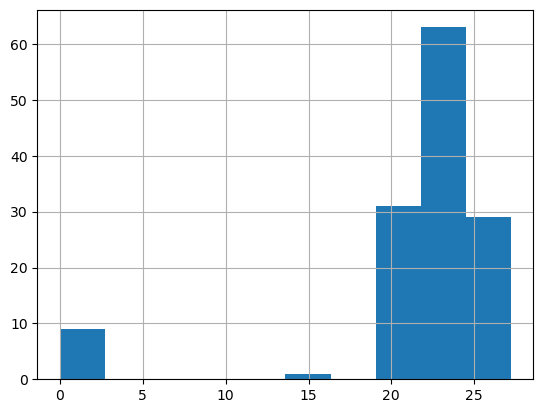

In [56]:
wdi_df_var[indicator_columns].sum(axis=1).apply(np.log1p).hist()

## Combining the data sets

In [58]:
# inspecting the 
dose.year.value_counts().order_by("year").to_pandas().tail(10)

,year,year_count
52,2011,1420
53,2012,1476
54,2013,1564
55,2014,1548
56,2015,1524
57,2016,1521
58,2017,1518
59,2018,1335
60,2019,1039
61,2020,354


In [59]:
dose.columns[0:9]

['country',
 'region',
 'gid_0',
 'gid_1',
 'year',
 'grp_lcu',
 'pop',
 'grp_pc_lcu',
 'ag_grp_pc_lcu']

### Using the year variable assigned earlier

In [61]:
# some columns
sample(dose.columns,5)

['country', 'region', 'gid_0', 'gid_1', 'year']

In [62]:
dose_year = dose.filter(_.year==str(year)).to_pandas()

In [63]:
# due to the way na values are written in the data set, all the data had to be read as strings, changing this here.
dose_year.replace(to_replace="#N/A",value=np.nan,inplace=True)

,country,region,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,man_grp_pc_lcu2015_usd,serv_grp_pc_lcu2015_usd,cpi_2015,deflator_2015,fx,ppp,struct_change,version,t_a,p_a
0,Albania,Berat,ALB,ALB.1_1,2015,54691123900,136904,399485.2152,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,13.50185305,1093.56268
1,Albania,Dibër,ALB,ALB.2_1,2015,46850206200,130056,360231.0251,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,10.45442675,1175.134798
2,Albania,Durrës,ALB,ALB.3_1,2015,1.40E+11,279097,502550.8411,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,16.16559071,1047.35031


In [ ]:
dose_year.head(3)

On the duckdb end all the data was stored as strings becuase the NA values were not interpretable as numeric. so converting back 


In [64]:
# have a look at the columns
sample(dose_year.columns)

Index(['country', 'region', 'gid_0', 'gid_1', 'year', 'grp_lcu', 'pop',
       'grp_pc_lcu', 'ag_grp_pc_lcu', 'man_grp_pc_lcu', 'serv_grp_pc_lcu',
       'grp_pc_usd', 'ag_grp_pc_usd', 'man_grp_pc_usd', 'serv_grp_pc_usd',
       'grp_pc_lcu_2015', 'ag_grp_pc_lcu_2015', 'man_grp_pc_lcu_2015',
       'serv_grp_pc_lcu_2015', 'grp_pc_usd_2015', 'ag_grp_pc_usd_2015',
       'man_grp_pc_usd_2015', 'serv_grp_pc_usd_2015', 'grp_pc_lcu2015_usd',
       'ag_grp_pc_lcu2015_usd', 'man_grp_pc_lcu2015_usd',
       'serv_grp_pc_lcu2015_usd', 'cpi_2015', 'deflator_2015', 'fx', 'ppp',
       'struct_change', 'version', 't_a', 'p_a'],
      dtype='object')

In [65]:
# The columns that we will use later will be multiplied, so this step is essential.
float_cols = dose_year.filter(regex="(lcu)|(usd)|(cpi)|(pop)|(year)|(T_a)|(P_a)|(PPP)|(2015)").columns.unique()
dose_year[float_cols] = dose_year[float_cols].astype(float)

In [66]:
gdp_thres = 1.1

In [67]:
#  IN NORMAL LCU
# But before checking if things add up
# 'grp_pc_lcu_2015',
#  'ag_grp_pc_lcu_2015',
#  'man_grp_pc_lcu_2015',
#  'serv_grp_pc_lcu_2015',

dose_year["manufacturing_lcu_2015"] = dose_year["man_grp_pc_lcu_2015"]*dose_year["pop"]
dose_year["services_lcu_2015"]=dose_year['serv_grp_pc_lcu_2015']*dose_year["pop"]
dose_year["agriculture_lcu_2015"]=dose_year['ag_grp_pc_lcu_2015']*dose_year["pop"]
dose_year["grp_lcu_2015"]=dose_year["grp_pc_lcu_2015"]*dose_year["pop"]



print("Inconsistencies in the DOSE data set in LCU_2015.")
print("When converting to absolute values : ",dose_year[((dose_year["manufacturing_lcu_2015"]+dose_year["services_lcu_2015"]+dose_year["agriculture_lcu_2015"])/dose_year["grp_lcu_2015"])>gdp_thres].shape[0])
print("In pc values : ", dose_year[((dose_year["man_grp_pc_lcu_2015"]+dose_year["serv_grp_pc_lcu_2015"]+dose_year["ag_grp_pc_lcu_2015"])/dose_year["grp_pc_lcu_2015"])>gdp_thres].shape[0])

Inconsistencies in the DOSE data set in LCU_2015.
When converting to absolute values :  23
In pc values :  23


In [68]:
# #  IN LCU2015_USD whatever it means

# 'grp_pc_lcu2015_usd',
#        'ag_grp_pc_lcu2015_usd', 'man_grp_pc_lcu2015_usd',
#        'serv_grp_pc_lcu2015_usd'

dose_year["manufacturing_lcu_2015_usd"] = dose_year["man_grp_pc_lcu2015_usd"]*dose_year["pop"]
dose_year["services_lcu_2015_usd"]=dose_year['serv_grp_pc_lcu2015_usd']*dose_year["pop"]
dose_year["agriculture_lcu_2015_usd"]=dose_year['ag_grp_pc_lcu2015_usd']*dose_year["pop"]
dose_year["grp_lcu_2015_usd"]=dose_year["grp_pc_lcu2015_usd"]*dose_year["pop"]

print("Inconsistencies in the DOSE data set in LCU2015_USD.")
print("When converting to absolute values : ",dose_year[((dose_year["manufacturing_lcu_2015_usd"]+dose_year["services_lcu_2015_usd"]+dose_year["agriculture_lcu_2015_usd"])/dose_year["grp_lcu_2015_usd"])>gdp_thres].shape[0])
print("In pc values : ", dose_year[((dose_year["man_grp_pc_lcu2015_usd"]+dose_year["serv_grp_pc_lcu2015_usd"]+dose_year["ag_grp_pc_lcu2015_usd"])/dose_year["grp_pc_lcu2015_usd"])>gdp_thres].shape[0])

Inconsistencies in the DOSE data set in LCU2015_USD.
When converting to absolute values :  23
In pc values :  23


<Axes: >

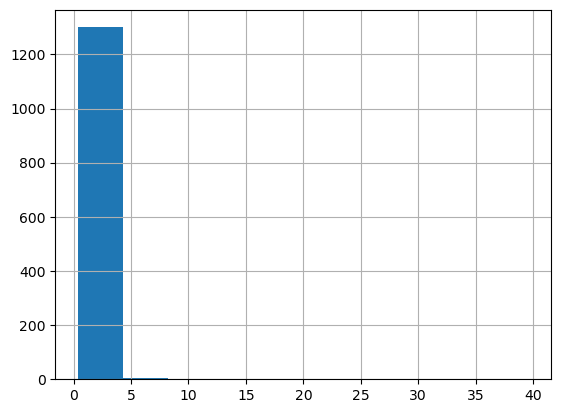

In [69]:
((dose_year["manufacturing_lcu_2015_usd"]+dose_year["services_lcu_2015_usd"]+dose_year["agriculture_lcu_2015_usd"])/dose_year["grp_lcu_2015_usd"]).hist()

## Filling population gaps in DOSE
The missing *population* values generates missing values when converting from per capita values back into absolute values.
#### Converting per capita into absolute values with the population variable.


In [70]:
dose_year.head(5)

,country,region,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,t_a,p_a,manufacturing_lcu_2015,services_lcu_2015,agriculture_lcu_2015,grp_lcu_2015,manufacturing_lcu_2015_usd,services_lcu_2015_usd,agriculture_lcu_2015_usd,grp_lcu_2015_usd
0,Albania,Berat,ALB,ALB.1_1,2015.0,5.469112e+10,136904.0,399485.2152,NaN,NaN,...,13.50185305,1093.56268,NaN,NaN,NaN,5.469112e+10,NaN,NaN,NaN,4.341915e+08
1,Albania,Dibër,ALB,ALB.2_1,2015.0,4.685021e+10,130056.0,360231.0251,NaN,NaN,...,10.45442675,1175.134798,NaN,NaN,NaN,4.685021e+10,NaN,NaN,NaN,3.719427e+08
2,Albania,Durrës,ALB,ALB.3_1,2015.0,1.400000e+11,279097.0,502550.8411,NaN,NaN,...,16.16559071,1047.35031,NaN,NaN,NaN,1.402604e+11,NaN,NaN,NaN,1.113524e+09
3,Albania,Elbasan,ALB,ALB.4_1,2015.0,1.000000e+11,289136.0,346548.9099,NaN,NaN,...,12.9849634,1017.524637,NaN,NaN,NaN,1.001998e+11,NaN,NaN,NaN,7.954835e+08
4,Albania,Fier,ALB,ALB.5_1,2015.0,1.690000e+11,306561.0,552703.4714,NaN,NaN,...,16.91313816,978.7869504,NaN,NaN,NaN,1.694373e+11,NaN,NaN,NaN,1.345159e+09


In [71]:
# filling some extra missing values of population to reconstruct the economic indicators. From sources on the net.
missing_pop = dose_year.loc[dose_year["pop"].isna(),["country","region","pop"]].copy()
# missing_pop.head()
# # writing out this file to refer to the missing values
# missing_pop["region"].to_csv("missing_pop.csv",index=False) 

missing_pop.set_index("region",inplace=True)

In [72]:
## strangely, Ireland is missing from the data, using it's census data to fill the gaps.
# https://data.gov.ie/dataset/population-classified-by-area 

# this data set : https://www.cso.ie/en/media/csoie/census/documents/saps2011files/AllThemesTablesCTY.csv

ireland = pd.read_csv("../datasets/support_data/ireland/AllThemesTablesCTY.csv"
                      ,encoding="UTF-8")
ireland.columns = [x.lower() for x in ireland.columns]
ireland.head(3)

# manually replaced Dublin City -> Dublin, Laois -> Laoighis in the data set.

# to many columns
ireland = ireland[["t1_1agett","geogdesc"]]


In [73]:
# renaming consistently
ireland.rename(columns={"t1_1agett":"pop"
                        ,"geogdesc":"region"},inplace=True)

# few cases to treat individually
tipperary_pop = ireland.loc[ireland.region.isin(["Tipperary North","Tipperary South"]),"pop"].sum()

missing_case = pd.DataFrame([{"region" : "Tipperary", "pop" : tipperary_pop}])

ireland = pd.concat([ireland,missing_case])

ireland.set_index("region",inplace=True)
# ireland.head()

,pop
region,
Carlow,54612
Dublin,527612
South Dublin,265205
Fingal,273991
Dún Laoghaire-Rathdown,206261


In [74]:
missing_index = [x for x in ireland.index if x in missing_pop.index]


In [75]:
missing_pop.loc[missing_index,"pop"] = ireland.loc[missing_index,"pop"]

In [76]:
# yey, ireland is in.
missing_pop.loc[missing_pop.country=="Ireland"].tail(3)

,country,pop
region,,
Westmeath,Ireland,86164.0
Wexford,Ireland,145320.0
Wicklow,Ireland,136640.0


In [77]:
# need to go back and forth between indexing based on the region and putting it back into the columns, the R function match() does that well. 
missing_pop.reset_index(inplace=True,drop=False)
# missing_pop.head()

,region,country,pop
0,Neuquen,Argentina,NaN
1,Tucuman,Argentina,NaN
2,Mato Grosso Do Sul,Brazil,NaN
3,Rio De Janeiro,Brazil,NaN
4,Rio Grande Do Norte,Brazil,NaN


In [78]:
# the fully manual bit, took some time.

# Argentina
missing_pop.loc[missing_pop.region=="Neuquen","pop"] = 744_592 # statista : https://www.statista.com/statistics/1413909/population-by-group-age-gender-neuquen-argentina
missing_pop.loc[missing_pop.region=="Tucuman","pop"] = 1.593e6 # wiki

# Brasil
missing_pop.loc[missing_pop.region=="Mato Grosso Do Sul","pop"] = 2_833_742 # https://www.britannica.com/place/Mato-Grosso-do-Sul
missing_pop.loc[missing_pop.region=="Rio De Janeiro","pop"] = 6_625_849 # https://www.britannica.com/place/Rio-de-Janeiro-Brazil
missing_pop.loc[missing_pop.region=="Rio Grande Do Norte","pop"] = 3_302_729 # https://cidades.ibge.gov.br/brasil/rn/panorama
missing_pop.loc[missing_pop.region=="Rio Grande Do Sul","pop"] = 11_329_605 # https://www.ceicdata.com/en/brazil/population/population-south-rio-grande-do-sul

# Canada
missing_pop.loc[missing_pop.region=="Newfoundland And Labrador","pop"] = 541_391 # https://www.gov.nl.ca/fin/economics/eb-population/

#Colombia
missing_pop.loc[missing_pop.region=="Norte de Santander","pop"] = 1_617_209 # https://www.citypopulation.de/en/colombia/admin/54__norte_de_santander/

# croatia
missing_pop.loc[missing_pop.region=="Slavonskibrod-Posavina","pop"] = 130_267 # https://www.citypopulation.de/en/croatia/admin/12__brod_posavina/

# Kazakhstan
missing_pop.loc[missing_pop.region=="Aktobe","pop"] = 944_600 # https://stat.gov.kz/en/region/aktobe/
missing_pop.loc[missing_pop.region=="Atirau","pop"] = 708_500 # https://stat.gov.kz/en/region/atyrau/
missing_pop.loc[missing_pop.region=="East Kazakhstan","pop"] = 731_246 # https://www.citypopulation.de/en/kazakhstan/cities/
missing_pop.loc[missing_pop.region=="Kostanay","pop"] = 827_900 # https://stat.gov.kz/en/region/kostanay/
missing_pop.loc[missing_pop.region=="North Kazakhstan","pop"] = 540_700 # 

# south Korea
missing_pop.loc[missing_pop.region=="Gangwond-do","pop"] = 1_521_763 # https://www.citypopulation.de/en/southkorea/admin/32__gangwon_do/

# Tanzania
missing_pop.loc[missing_pop.region=="Arusha","pop"] = 2_356_255 # https://www.citypopulation.de/en/tanzania/admin/02__arusha/
missing_pop.loc[missing_pop.region=="Dar es salaam","pop"] = 8_161_231 # https://worldpopulationreview.com/cities/tanzania/dar-es-salaam
missing_pop.loc[missing_pop.region=="Dodoma","pop"] = 3_085_625 # https://www.citypopulation.de/en/tanzania/admin/01__dodoma/
missing_pop.loc[missing_pop.region=="Geita","pop"] = 2_977_608 # https://www.citypopulation.de/en/tanzania/admin/25__geita
missing_pop.loc[missing_pop.region=="Iringa","pop"] = 1_192_728 # http://www.citypopulation.de/en/tanzania/admin/11__iringa/
missing_pop.loc[missing_pop.region=="Kagera","pop"] = 2_989_299 # https://www.citypopulation.de/en/tanzania/admin/18/
missing_pop.loc[missing_pop.region=="Katavi","pop"] = 1_152_958 # https://citypopulation.de/en/tanzania/admin/23__katavi/
missing_pop.loc[missing_pop.region=="Kigoma","pop"] = 2_470_967 # https://citypopulation.de/en/tanzania/admin/
missing_pop.loc[missing_pop.region=="Kilimanjaro","pop"] = 1_861_934 # ---
missing_pop.loc[missing_pop.region=="Lindi","pop"] = 1_194_028 # ---
missing_pop.loc[missing_pop.region=="Manyara","pop"] = 1_892_502 # ---
missing_pop.loc[missing_pop.region=="Mara","pop"] = 2_372_015 # ---
missing_pop.loc[missing_pop.region=="Mbeya","pop"] = 2_343_754 # ---
missing_pop.loc[missing_pop.region=="Morogoro","pop"] = 3_197_104 # ---
missing_pop.loc[missing_pop.region=="Mtwara","pop"] = 1_634_947 # ---
missing_pop.loc[missing_pop.region=="Mwanza","pop"] = 3_699_872 # ---
missing_pop.loc[missing_pop.region=="Njombe","pop"] = 889_946 # ---
missing_pop.loc[missing_pop.region=="Pwani","pop"] = 2_024_947 # ---
missing_pop.loc[missing_pop.region=="Rukwa","pop"] = 1_540_519 # ---
missing_pop.loc[missing_pop.region=="Ruvuma","pop"] = 1_848_794 # ---
missing_pop.loc[missing_pop.region=="Shinyanga","pop"] = 2_241_299 # ---
missing_pop.loc[missing_pop.region=="Singida","pop"] = 2_008_058 # ---
missing_pop.loc[missing_pop.region=="Tabora","pop"] = 3_391_679 # ---
missing_pop.loc[missing_pop.region=="Tanga","pop"] = 2_615_597 # ---

# Ukraine
missing_pop.loc[missing_pop.region=="Dnipropetrovsk","pop"] = 1_145_065 # https://www.citypopulation.de/en/ukraine/
missing_pop.loc[missing_pop.region=="Kyiv City","pop"] = 2_952_301 # https://www.citypopulation.de/en/ukraine/kievcity/

In [79]:
# no 'fx' is na
# dose_year[dose_year["fx"].isna()]
# NA for gid_0=="ANT"
# dose_year[dose_year["deflator_2015"].isna()]
# # dose_year[dose_year.gid_0=="ANT"]
# lcu_vars = [x for x in dose_year.columns if re.search(string=x,pattern="_lcu")]
# dose_year[lcu_vars].isna() 

### Putting the missing populations back in

In [80]:
dose_year.set_index("region",inplace=True)
missing_pop.set_index("region",inplace=True)

In [81]:
# yeahhhh
dose_year.loc[missing_pop.index,"pop"] = missing_pop["pop"]

In [82]:
# resetting back the index.
dose_year.reset_index(inplace=True,drop=False)

## Converting to absolute GDP values
Computing grp values in usd_2015.

In [83]:
# USD

dose_year["agriculture_usd_2015"] = dose_year["ag_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["manufacturing_usd_2015"] = dose_year["man_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["services_usd_2015"] = dose_year["serv_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["grp_usd_2015"] = dose_year["grp_pc_usd_2015"]*dose_year["pop"]

# LCU
# 
# dose_year["agriculture_lcu_2015"] = dose_year["ag_grp_pc_lcu_2015"]*dose_year["pop"]
# dose_year["manufacturing_lcu_2015"] = dose_year["man_grp_pc_lcu_2015"]*dose_year["pop"]
# dose_year["services_lcu_2015"] = dose_year["serv_grp_pc_lcu_2015"]*dose_year["pop"]
# dose_year["grp_lcu_2015"] = dose_year["grp_pc_lcu_2015"]*dose_year["pop"]


### missing values from lcu and usd

In [84]:
# dose_year.loc[dose_year.filter(regex="_lcu_").isna().any(axis=1),dose_year.filter(regex="_usd_").columns]
dose_year.loc[dose_year.filter(regex="^grp_pc_lcu_").isna().any(axis=1),dose_year.filter(regex="(_usd_)|(gid_)").columns]

,gid_0,gid_1,grp_pc_usd_2015,ag_grp_pc_usd_2015,man_grp_pc_usd_2015,serv_grp_pc_usd_2015,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015
779,ANT,BES.1_1,24649.56361,NaN,NaN,NaN,NaN,NaN,NaN,4.660000e+08
780,ANT,BES.2_1,25952.51242,NaN,NaN,NaN,NaN,NaN,NaN,4.700000e+07
781,ANT,BES.3_1,34562.80629,NaN,NaN,NaN,NaN,NaN,NaN,1.340000e+08


In [85]:
# dose_year.loc[dose_year.filter(regex="_lcu_").isna().any(axis=1),dose_year.filter(regex="_lcu_").columns]
dose_year.loc[dose_year.filter(regex="^grp_pc_usd_").isna().any(axis=1),dose_year.filter(regex="(_usd_)|(gid_)").columns]

,gid_0,gid_1,grp_pc_usd_2015,ag_grp_pc_usd_2015,man_grp_pc_usd_2015,serv_grp_pc_usd_2015,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015


In [86]:
dose_year.grp_pc_usd_2015.isna().any()

False

In [87]:
dose_year[dose_year["pop"].isna()]

,region,country,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,agriculture_lcu_2015,grp_lcu_2015,manufacturing_lcu_2015_usd,services_lcu_2015_usd,agriculture_lcu_2015_usd,grp_lcu_2015_usd,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015
865,NaN,Philippines,PHL,PHL.109_1,2015.0,9.918561e+10,NaN,2.365159e+04,14387.34929,1179.344398,...,6.033498e+10,9.918561e+10,1.086902e+08,7.451162e+08,1.325961e+09,2.179767e+09,NaN,NaN,NaN,NaN
1206,NaN,Tanzania,TZA,None,2015.0,NaN,NaN,1.567157e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Do things add up ? 


In [88]:
# in USD
dose_year[np.abs((dose_year["manufacturing_usd_2015"]+dose_year["services_usd_2015"]+dose_year["agriculture_usd_2015"])/dose_year["grp_usd_2015"])>1.1].head()

,region,country,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,agriculture_lcu_2015,grp_lcu_2015,manufacturing_lcu_2015_usd,services_lcu_2015_usd,agriculture_lcu_2015_usd,grp_lcu_2015_usd,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015
397,Andhra Pradesh,India,IND,IND.2_1,2015.0,4.880000e+12,51012200.0,95672.85500,3.722380e+06,24380.167940,...,1.898868e+14,4.880483e+12,1.938657e+10,3.357343e+10,2.959954e+12,7.607693e+10,2.959954e+12,1.938657e+10,3.357343e+10,7.607693e+10
399,Assam,India,IND,IND.4_1,2015.0,1.840000e+12,32775600.0,56268.21868,3.586045e+05,12564.697200,...,1.175348e+13,1.844225e+12,6.419377e+09,1.384176e+10,1.832131e+11,2.874776e+10,1.832131e+11,6.419377e+09,1.384176e+10,2.874776e+10
400,Bihar,India,IND,IND.5_1,2015.0,3.350000e+12,112160600.0,29906.44784,2.294282e+04,5885.672004,...,2.573280e+12,3.354325e+12,1.029026e+10,2.959853e+10,4.011227e+10,5.228719e+10,4.011227e+10,1.029026e+10,2.959853e+10,5.228719e+10
402,Chattisgarh,India,IND,IND.7_1,2015.0,2.090000e+12,27165800.0,77013.46368,5.385435e+05,26569.178690,...,1.462997e+13,2.092132e+12,1.125099e+10,1.134110e+10,2.280518e+11,3.261214e+10,2.280518e+11,1.125099e+10,1.134110e+10,3.261214e+10
405,Gujarat,India,IND,IND.11_1,2015.0,8.250000e+12,64214400.0,128445.84050,1.034242e+06,56871.319540,...,6.641324e+13,8.248073e+12,5.692669e+10,4.666193e+10,1.035249e+12,1.285709e+11,1.035249e+12,5.692669e+10,4.666193e+10,1.285709e+11


In [89]:
# in LCU
dose_year[np.abs((dose_year["manufacturing_lcu_2015"]+dose_year["services_lcu_2015"]+dose_year["agriculture_lcu_2015"])/dose_year["grp_lcu_2015"])>1.1].head()

,region,country,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,agriculture_lcu_2015,grp_lcu_2015,manufacturing_lcu_2015_usd,services_lcu_2015_usd,agriculture_lcu_2015_usd,grp_lcu_2015_usd,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015
397,Andhra Pradesh,India,IND,IND.2_1,2015.0,4.880000e+12,51012200.0,95672.85500,3.722380e+06,24380.167940,...,1.898868e+14,4.880483e+12,1.938657e+10,3.357343e+10,2.959954e+12,7.607693e+10,2.959954e+12,1.938657e+10,3.357343e+10,7.607693e+10
399,Assam,India,IND,IND.4_1,2015.0,1.840000e+12,32775600.0,56268.21868,3.586045e+05,12564.697200,...,1.175348e+13,1.844225e+12,6.419377e+09,1.384176e+10,1.832131e+11,2.874776e+10,1.832131e+11,6.419377e+09,1.384176e+10,2.874776e+10
400,Bihar,India,IND,IND.5_1,2015.0,3.350000e+12,112160600.0,29906.44784,2.294282e+04,5885.672004,...,2.573280e+12,3.354325e+12,1.029026e+10,2.959853e+10,4.011227e+10,5.228719e+10,4.011227e+10,1.029026e+10,2.959853e+10,5.228719e+10
402,Chattisgarh,India,IND,IND.7_1,2015.0,2.090000e+12,27165800.0,77013.46368,5.385435e+05,26569.178690,...,1.462997e+13,2.092132e+12,1.125099e+10,1.134110e+10,2.280518e+11,3.261214e+10,2.280518e+11,1.125099e+10,1.134110e+10,3.261214e+10
405,Gujarat,India,IND,IND.11_1,2015.0,8.250000e+12,64214400.0,128445.84050,1.034242e+06,56871.319540,...,6.641324e+13,8.248073e+12,5.692669e+10,4.666193e+10,1.035249e+12,1.285709e+11,1.035249e+12,5.692669e+10,4.666193e+10,1.285709e+11


### Data sets light

In [90]:
# the light version is reduced to the variables of interest only. This includes a specific year, sector and total gdp(grp) values.
dose_light = dose_year[["country","gid_0","gid_1","grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"]].copy()

In [94]:
wdi_df_var.dropna(subset=["grp_usd_2015"],inplace=True)

In [95]:
# WDI is also reduced to the essential in order to concat the data sets later on.
# this step could be done at an earlier stage as well to avoid redundancy.
wdi_country_simple = wdi_df_var.loc[:,~wdi_df_var.columns.isin(["gdp_cap"])]

## Combining 
Using the fact that columns are named the same.

#### The column names should match

In [96]:
dose_light.head(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN


### Do things add up at this point ?

In [97]:
dose_light.loc[((dose_light["manufacturing_usd_2015"]+dose_light["services_usd_2015"]+dose_light["agriculture_usd_2015"])/dose_light["grp_usd_2015"])>1.1]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
397,India,IND,IND.2_1,7.607693e+10,3.357343e+10,1.938657e+10,2.959954e+12
399,India,IND,IND.4_1,2.874776e+10,1.384176e+10,6.419377e+09,1.832131e+11
400,India,IND,IND.5_1,5.228719e+10,2.959853e+10,1.029026e+10,4.011227e+10
402,India,IND,IND.7_1,3.261214e+10,1.134110e+10,1.125099e+10,2.280518e+11
405,India,IND,IND.11_1,1.285709e+11,4.666193e+10,5.692669e+10,1.035249e+12
408,India,IND,IND.14_1,1.452550e+10,8.502779e+09,3.604522e+09,4.203577e+09
409,India,IND,IND.15_1,3.132182e+10,1.219931e+10,9.625152e+09,2.515173e+10
412,India,IND,IND.19_1,7.116199e+10,2.753653e+10,1.563218e+10,6.150215e+10
417,India,IND,IND.24_1,2.845844e+09,1.559493e+09,3.084235e+08,1.676656e+09
418,India,IND,IND.26_1,4.604805e+10,1.892777e+10,1.267556e+10,2.899032e+11


<Axes: >

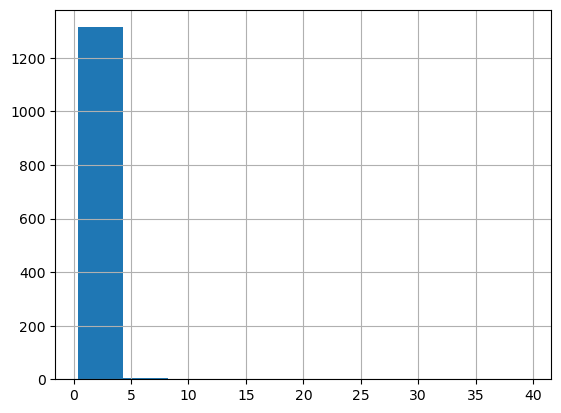

In [98]:
((dose_light["manufacturing_usd_2015"]+dose_light["services_usd_2015"]+dose_light["agriculture_usd_2015"])/dose_light["grp_usd_2015"]).hist()

In [99]:
# NO THEY DONT !!

In [101]:
wdi_country_simple = (wdi_country_simple.assign(gid_0=wdi_country_simple["country_code"]
                                                ,gid_1=wdi_country_simple["country_code"])
                                                .drop(columns=["country_code"]))

In [102]:
if wdi_country_simple.columns.difference(dose_light.columns).__len__()!=0:
    raise Exception("Some columns don't match in the data sets, concatenation behaviour will be unexpected.")

In [103]:
[x for x in dose_light.country if x in wdi_country_simple.country]

[]

### filling admin 1 gaps in dose with WDI

The process : 
when a country in DOSE has missing sectorial values, take the proportion of per sector gdp in WDI for the national scale and replace in DOSE.

In [104]:
incomplete_dose = list(dose_light.loc[dose_light[["services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015","grp_usd_2015"]].isna().any(axis=1),"gid_0"].unique())

In [105]:
# get the data of interest into a pandas df
# wdi_df_full contains the same countries as the original dose
wdi_df_full = (wdi_of_interest
               .filter(~_.country_code.isin(missing_regions),_.country_code.isin(dose_countries))
               .to_pandas()
               .pivot(columns=["indicator_name",],values=[str(year)],index=["country_name","country_code"]).reset_index())

wdi_df_full.rename(columns={v:k for (k,v) in indicators_of_intereset.items()} # inverting the indicators of interest to rename columns
                  ,inplace=True)
wdi_df_full.columns = [x[1] if x[1]!='' else x[0] for x in wdi_df_full.columns]
wdi_df_full.columns = [x.replace("industry", "manufacturing") if re.search(string=x,pattern="industry_") else x for x in wdi_df_full.columns]

In [106]:
wdi_df_full.head()

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Albania,ALB,2.252344e+09,1.138685e+10,3952.803574,2.478198e+09,5.270341e+09
1,Argentina,ARG,3.066935e+10,5.947493e+11,13789.060425,1.377026e+11,3.319587e+11
2,Australia,AUS,3.210833e+10,1.351769e+12,56758.869203,3.201382e+11,9.077942e+11
3,Austria,AUT,4.315473e+09,3.819711e+11,44195.817595,9.616091e+10,2.401859e+11
4,Azerbaijan,AZE,3.278761e+09,5.307624e+10,5500.503646,2.382662e+10,2.122835e+10


In [107]:
# This data frame name is a bit confusing, but it contains WDI data missing from dose.
dose_missing_df = wdi_df_full.loc[wdi_df_full.country_code.isin(incomplete_dose)].copy()

In [108]:
# should not be empty
print("Any value missing: ",dose_missing_df.isna().any().any())

Any value missing:  False


,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
65,Tanzania,TZA,1.268127e+10,4.741392e+10,929.799805,1.161041e+10,1.917000e+10
51,Paraguay,PRY,3.418513e+09,3.621145e+10,5861.401895,1.252273e+10,1.761408e+10
9,Bosnia and Herzegovina,BIH,9.904235e+08,1.640435e+10,4654.608620,3.564084e+09,9.010718e+09
35,Kenya,KEN,1.365218e+10,7.012045e+10,1496.653573,1.324859e+10,3.935957e+10
71,Uzbekistan,UZB,2.518717e+10,8.619626e+10,2753.971058,1.941180e+10,3.375191e+10


In [ ]:
dose_missing_df.sample(5,axis=0)

In [109]:
dose_missing_df.reset_index(inplace=True,drop=True)

In [110]:
# computing fractions of GDP per sector from WDI

dose_missing_df["services_frac"] = dose_missing_df["services_usd_2015"]/dose_missing_df["grp_usd_2015"]
dose_missing_df["manufacturing_frac"] = (dose_missing_df["manufacturing_usd_2015"]/dose_missing_df["grp_usd_2015"])
dose_missing_df["agriculture_frac"] = dose_missing_df["agriculture_usd_2015"]/dose_missing_df["grp_usd_2015"]

# dose_missing_df["industry_frac"] = dose_missing_df["industry_usd_2015"]/dose_missing_df["grp_usd_2015"]


In [111]:
dose_missing_df.loc[dose_missing_df.country=="Uzbekistan"]

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015,services_frac,manufacturing_frac,agriculture_frac
11,Uzbekistan,UZB,2.518717e+10,8.619626e+10,2753.971058,1.941180e+10,3.375191e+10,0.39157,0.225205,0.292207


<Axes: >

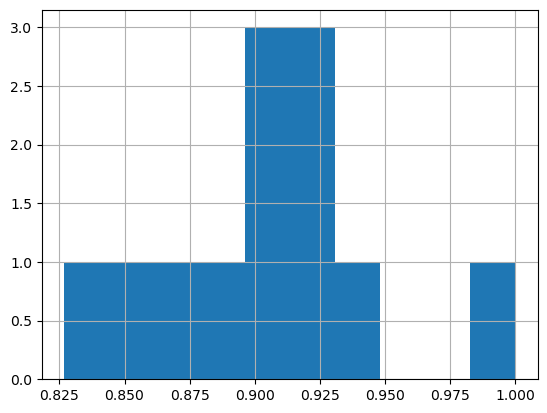

In [112]:
# looking much better now

dose_missing_df.filter(regex="_frac").apply(sum,axis=1).hist()

To avoid mixing up WDI, first fill in gaps from dose regions with WDI fracions of GDP per sector for industies

Then combine with the missing regions/countries

In [113]:
# dose_missing_df.filter(regex="(_frac)|(country_code)")
dose_light = dose_light.merge(dose_missing_df.filter(regex="(_frac)|(country_code)"),left_on="gid_0",right_on="country_code",how="left",suffixes=["_dose","_wdi"])

In [114]:
dose_light.columns

Index(['country', 'gid_0', 'gid_1', 'grp_usd_2015', 'services_usd_2015',
       'manufacturing_usd_2015', 'agriculture_usd_2015', 'country_code',
       'services_frac', 'manufacturing_frac', 'agriculture_frac'],
      dtype='object')

In [115]:
# dose_light[dose_light.country=="Laos"]

In [116]:
missing_agriculture = dose_light[dose_light["agriculture_usd_2015"].isna()].index
missing_services = dose_light[dose_light["services_usd_2015"].isna()].index
missing_manufacturing = dose_light[dose_light["manufacturing_usd_2015"].isna()].index

missing_grp = dose_light[dose_light["grp_usd_2015"].isna()].index

In [118]:
dose_light.loc[missing_agriculture,"agriculture_usd_2015"] = dose_light.loc[missing_agriculture,"agriculture_frac"]*dose_light.loc[missing_agriculture,"grp_usd_2015"]

dose_light.loc[missing_manufacturing,"manufacturing_usd_2015"] = dose_light.loc[missing_manufacturing,"manufacturing_frac"]*dose_light.loc[missing_manufacturing,"grp_usd_2015"]

dose_light.loc[missing_services,"services_usd_2015"] = dose_light.loc[missing_services,"services_frac"]*dose_light.loc[missing_services,"grp_usd_2015"]

# dose_light.loc[missing_grp,"grp_usd_2015"] = dose_light.loc[missing_services,"grp_usd_2015_"]

In [119]:
dose_light.iloc[missing_agriculture]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,country_code,services_frac,manufacturing_frac,agriculture_frac
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07,ALB,0.462844,0.217637,0.197802
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07,ALB,0.462844,0.217637,0.197802
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08,ALB,0.462844,0.217637,0.197802
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08,ALB,0.462844,0.217637,0.197802
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08,ALB,0.462844,0.217637,0.197802
...,...,...,...,...,...,...,...,...,...,...,...
1456,Uzbekistan,UZB,UZB.10_1,7.209421e+09,2.822996e+09,1.623595e+09,2.106645e+09,UZB,0.391570,0.225205,0.292207
1457,Uzbekistan,UZB,UZB.11_1,1.976996e+09,7.741331e+08,4.452286e+08,5.776924e+08,UZB,0.391570,0.225205,0.292207
1458,Uzbekistan,UZB,UZB.12_1,4.328059e+09,1.694740e+09,9.746988e+08,1.264690e+09,UZB,0.391570,0.225205,0.292207
1459,Uzbekistan,UZB,UZB.14_1,8.601678e+09,3.368163e+09,1.937138e+09,2.513472e+09,UZB,0.391570,0.225205,0.292207


In [120]:
dose_light = dose_light.drop(columns=["country_code",*[x for x in dose_light.columns if re.search(string = x,pattern="(_frac)|(_2015_wdi)")]])

In [121]:
# still some NAs
print(dose_light.loc[dose_light.isna().any(axis=1)].shape)

dose_light.loc[dose_light.isna().any(axis=1)]

(5, 7)


,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
779,Netherlands Antilles,ANT,BES.1_1,4.660000e+08,NaN,NaN,NaN
780,Netherlands Antilles,ANT,BES.2_1,4.700000e+07,NaN,NaN,NaN
781,Netherlands Antilles,ANT,BES.3_1,1.340000e+08,NaN,NaN,NaN
865,Philippines,PHL,PHL.109_1,NaN,NaN,NaN,NaN
1206,Tanzania,TZA,None,NaN,NaN,NaN,NaN


In [122]:
dose_light.shape

(1524, 7)

In [123]:
# dose_light[dose_light.country=="Colombia"]

In [124]:
print(wdi_country_simple.shape)
wdi_country_simple.head()

(130, 7)


,country,agriculture_usd_2015,grp_usd_2015,manufacturing_usd_2015,services_usd_2015,gid_0,gid_1
0,Afghanistan,3.948217e+09,1.913422e+10,4.233263e+09,1.018616e+10,AFG,AFG
1,Algeria,1.974833e+10,1.874939e+11,6.141643e+10,9.770374e+10,DZA,DZA
2,American Samoa,NaN,6.730000e+08,NaN,NaN,ASM,ASM
3,Andorra,1.432381e+07,2.789881e+09,2.784655e+08,2.194727e+09,AND,AND
4,Angola,8.255567e+09,9.049642e+10,3.794795e+10,4.403546e+10,AGO,AGO


In [125]:
wdi_country_simple.loc[wdi_country_simple.gid_0=="VEN"]

,country,agriculture_usd_2015,grp_usd_2015,manufacturing_usd_2015,services_usd_2015,gid_0,gid_1
127,"Venezuela, RB",1.573330e+10,3.347510e+11,1.352394e+11,1.837783e+11,VEN,VEN


### Now combine the WDI data with filled missing regional gdp with missing countries from WDI.

In [126]:
dose_light_combined = pd.concat([dose_light,wdi_country_simple],axis=0).reset_index(drop=True)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08


In [ ]:
dose_light_combined.head()

In [127]:
dose_light_combined.shape

(1654, 7)

In [128]:
dose_light_combined[dose_light_combined.isna().any(axis=1)].head()

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
779,Netherlands Antilles,ANT,BES.1_1,4.660000e+08,NaN,NaN,NaN
780,Netherlands Antilles,ANT,BES.2_1,4.700000e+07,NaN,NaN,NaN
781,Netherlands Antilles,ANT,BES.3_1,1.340000e+08,NaN,NaN,NaN
865,Philippines,PHL,PHL.109_1,NaN,NaN,NaN,NaN
1206,Tanzania,TZA,None,NaN,NaN,NaN,NaN


In [129]:
print("Data to this point: ",dose_light_combined.shape)
print("Full row of NAs removed: ", dose_light_combined.dropna(axis=0,how="all").shape)
print("Some missing economic indicator removed: ", dose_light_combined.dropna(subset=["grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"],axis=0,how="any").shape)

Data to this point:  (1654, 7)
Full row of NAs removed:  (1654, 7)
Some missing economic indicator removed:  (1640, 7)


## Complementary filling

We have GDP = agriculture + manufacturing + services. If any single value of the rhs is missing, we can find it. If lhs is missing, we can sum rhs.

next, a function will check this. 

In [130]:
dose_light_combined.head(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08


In [131]:
# function to find the missing values in rows and fill them if possible
def check_and_fill_row(row: pd.Series):
    lhs = [x for x in row.index.tolist() if re.search(string=x, pattern="(gdp)|(grp)")]
    rhs = [x for x in row.index.tolist() if re.search(string=x, pattern="(manufacturing)|(services)|(agriculture)")]

    if row[lhs].isna().item() and (not row[rhs].isna().any().item()):
        row[lhs]=row[rhs].sum()
    
    elif (not row[lhs].isna().item()) and row[rhs].isna().sum()==1:
        which = row[rhs].isna()[row[rhs].isna()].index.tolist()
        # assign to the missing values in the rhs, the value of the lhs minus the values of the other rhs variables.
        row[which] = row[lhs]-row[[x for x in rhs if x not in which]].sum()
    else:
        pass

    return row

In [132]:
dose_light_combined[dose_light_combined.isna().any(axis=1)] = dose_light_combined[dose_light_combined.isna().any(axis=1)].apply(check_and_fill_row,axis=1)


In [133]:
print("Data to this point: ",dose_light_combined.shape)
print("Full row of NAs removed: ", dose_light_combined.dropna(axis=0,how="all").shape)
print("Some missing economic indicator removed: ", dose_light_combined.dropna(subset=["grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"],axis=0,how="any").shape)

Data to this point:  (1654, 7)
Full row of NAs removed:  (1654, 7)
Some missing economic indicator removed:  (1642, 7)


In [134]:
# 6 values have no economic information at all and will be removed in the next step
dose_light_combined[dose_light_combined.isna().any(axis=1)]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
779,Netherlands Antilles,ANT,BES.1_1,4.660000e+08,NaN,NaN,NaN
780,Netherlands Antilles,ANT,BES.2_1,4.700000e+07,NaN,NaN,NaN
781,Netherlands Antilles,ANT,BES.3_1,1.340000e+08,NaN,NaN,NaN
865,Philippines,PHL,PHL.109_1,NaN,NaN,NaN,NaN
1206,Tanzania,TZA,None,NaN,NaN,NaN,NaN
1526,American Samoa,ASM,ASM,6.730000e+08,NaN,NaN,NaN
1570,Guam,GUM,GUM,5.799000e+09,NaN,NaN,NaN
1590,Liechtenstein,LIE,LIE,6.268515e+09,NaN,2.335665e+09,NaN
1604,Nauru,NRU,NRU,8.486344e+07,NaN,NaN,NaN
1609,Northern Mariana Islands,MNP,MNP,9.100000e+08,NaN,NaN,NaN


In [135]:
# writing back the modified data set into the original one. this can be avoided and all the operations can be done on the original one right away once the workflow is good. 
dose_light_combined.dropna(subset=["grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"],axis=0,how="all",inplace=True)
dose_light_combined.reset_index(inplace=True,drop=True)

In [136]:
dose_light_combined

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08
...,...,...,...,...,...,...,...
1647,Virgin Islands (U.S.),VIR,VIR,3.663000e+09,NaN,NaN,NaN
1648,West Bank and Gaza,PSE,PSE,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09
1649,"Yemen, Rep.",YEM,YEM,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09
1650,Zambia,ZMB,ZMB,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09


In [137]:
dose_light_combined[dose_light_combined.gid_0=="VEN"]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
1646,"Venezuela, RB",VEN,VEN,3.347510e+11,1.837783e+11,1.352394e+11,1.573330e+10


## Validations
Running some tests on the data to identify problems

In [138]:
dose_light_combined[((dose_light_combined["manufacturing_usd_2015"]+dose_light_combined["services_usd_2015"]+dose_light_combined["agriculture_usd_2015"])/dose_light_combined["grp_usd_2015"])>1.1]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
397,India,IND,IND.2_1,7.607693e+10,3.357343e+10,1.938657e+10,2.959954e+12
399,India,IND,IND.4_1,2.874776e+10,1.384176e+10,6.419377e+09,1.832131e+11
400,India,IND,IND.5_1,5.228719e+10,2.959853e+10,1.029026e+10,4.011227e+10
402,India,IND,IND.7_1,3.261214e+10,1.134110e+10,1.125099e+10,2.280518e+11
405,India,IND,IND.11_1,1.285709e+11,4.666193e+10,5.692669e+10,1.035249e+12
408,India,IND,IND.14_1,1.452550e+10,8.502779e+09,3.604522e+09,4.203577e+09
409,India,IND,IND.15_1,3.132182e+10,1.219931e+10,9.625152e+09,2.515173e+10
412,India,IND,IND.19_1,7.116199e+10,2.753653e+10,1.563218e+10,6.150215e+10
417,India,IND,IND.24_1,2.845844e+09,1.559493e+09,3.084235e+08,1.676656e+09
418,India,IND,IND.26_1,4.604805e+10,1.892777e+10,1.267556e+10,2.899032e+11


<Axes: >

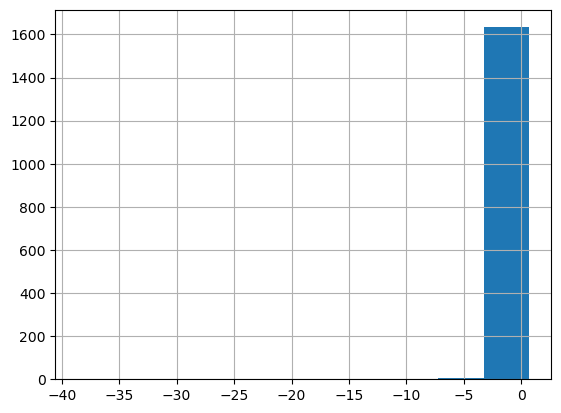

In [139]:
((dose_light_combined["grp_usd_2015"]-dose_light_combined["manufacturing_usd_2015"]-dose_light_combined["services_usd_2015"]-dose_light_combined["agriculture_usd_2015"])/dose_light_combined["grp_usd_2015"]).hist()

In [140]:
# dose_light.head(3)
wdi_df_var.head(3)

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Algeria,DZA,1.974833e+10,1.874939e+11,4741.499770,6.141643e+10,9.770374e+10
2,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN


In [141]:
dose_light

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08
...,...,...,...,...,...,...,...
1519,Vietnam,VNM,VNM.19_1,2.912262e+09,1.644608e+09,8.937407e+08,5.696491e+07
1520,Vietnam,VNM,VNM.16_1,9.437463e+08,2.968536e+08,1.331486e+08,4.877044e+08
1521,Vietnam,VNM,VNM.15_1,2.639374e+09,1.107037e+09,3.491636e+08,1.123582e+09
1522,Vietnam,VNM,VNM.17_1,1.051774e+10,2.348005e+09,6.212079e+09,1.013385e+09


In [142]:
print(wdi_df_var[wdi_df_var["grp_usd_2015"].isna()].shape)
wdi_df_var.reset_index(inplace=True,drop=True)
wdi_df_var.head()

(0, 7)


,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Algeria,DZA,1.974833e+10,1.874939e+11,4741.499770,6.141643e+10,9.770374e+10
2,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN
3,Andorra,AND,1.432381e+07,2.789881e+09,38885.530322,2.784655e+08,2.194727e+09
4,Angola,AGO,8.255567e+09,9.049642e+10,3217.339240,3.794795e+10,4.403546e+10


In [143]:
val = (dose_light[["gid_0","grp_usd_2015"]]
    .groupby("gid_0").sum()
    .merge(wdi_df_full[["country","country_code","grp_usd_2015"]],how="left",left_on="gid_0",right_on="country_code",suffixes=("_dose","_wdi")))
val

,grp_usd_2015_dose,country,country_code,grp_usd_2015_wdi
0,1.138692e+10,Albania,ALB,1.138685e+10
1,6.470000e+08,NaN,NaN,NaN
2,4.105693e+11,Argentina,ARG,5.947493e+11
3,1.220506e+12,Australia,AUS,1.351769e+12
4,3.818610e+11,Austria,AUT,3.819711e+11
...,...,...,...,...
69,8.502612e+10,Ukraine,UKR,9.103097e+10
70,1.812635e+13,United States,USA,1.829502e+13
71,7.408962e+10,Uzbekistan,UZB,8.619626e+10
72,2.224252e+11,Viet Nam,VNM,2.392583e+11


<Axes: >

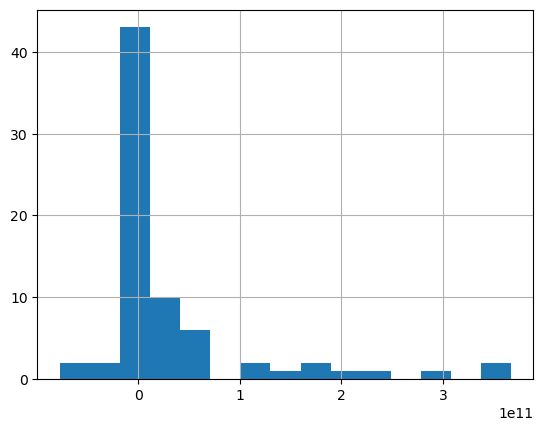

In [144]:
# The wdi GDP data tends to be greater that the DOSE value which makes some sens as it is supposed to have more sectors. 
(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"]).hist(bins=15) # .apply(np.log1p)

<Axes: >

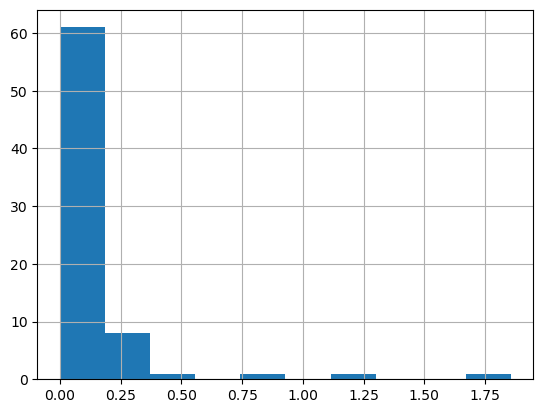

In [145]:
abs_diff = (np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"])#.isna()#.hist(bins=15)

# we aim to cluster all the values close to 0
abs_diff.hist(bins=10)

In [146]:
val.loc[(np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"]) > .15,]

,grp_usd_2015_dose,country,country_code,grp_usd_2015_wdi
2,4.105693e+11,Argentina,ARG,5.947493e+11
7,4.370948e+10,Bulgaria,BGR,5.081200e+10
10,4.164175e+10,Belarus,BLR,5.645489e+10
17,2.547149e+11,Colombia,COL,2.934924e+11
20,2.574787e+11,Denmark,DNK,3.026731e+11
24,1.940502e+10,Estonia,EST,2.289076e+10
25,1.829793e+11,Finland,FIN,2.345344e+11
33,1.755689e+12,India,IND,2.103588e+12
34,1.023588e+11,Ireland,IRL,2.923642e+11
39,5.831810e+10,Kenya,KEN,7.012045e+10


## Saving the combined file.

In [147]:
import os

version = "0_3"

dir_name = f"../datasets/local_data/dose-wdi/"

filename_dose_light = f"{dir_name}{version}/dose_light_combined_{year}_{version}.csv"
filename_dose_light


'../datasets/local_data/dose-wdi/0_3/dose_light_combined_2015_0_3.csv'

In [148]:

if not os.path.exists(f"{dir_name}{version}"):
    os.mkdir(f"{dir_name}{version}")

if os.path.exists(filename_dose_light):
    print(Warning("File already exists, erase before if you want to regenerate, or update version"))
    # dose_light_combined.to_csv()
else: 
    print(f"Writing file locally to '{filename_dose_light}'.")
    dose_light_combined.to_csv(filename_dose_light,index=False)

Writing file locally to '../datasets/local_data/dose-wdi/0_3/dose_light_combined_2015_0_3.csv'.


### Reading the local file

In [149]:
print(dose_light_combined.shape)
dose_light_combined.head(3)

(1652, 7)


,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08


In [150]:
if os.path.exists(filename_dose_light):
    print("Reading local file")
    dose_light_combined = pd.read_csv(filename_dose_light)
else :
    raise IOError("Could not find file.")

Reading local file


In [151]:
dose_light_combined.loc[dose_light_combined.gid_0=="VEN"]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
1646,"Venezuela, RB",VEN,VEN,3.347510e+11,1.837783e+11,1.352394e+11,1.573330e+10


In [152]:
dose_light_combined.loc[dose_light_combined["grp_usd_2015"].isna()]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015


In [153]:
dose_light_combined.loc[dose_light_combined["gid_1"].isna()]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015


In [154]:
print((dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015"]).shape[0])/dose_light_combined.shape[0])

dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015"]).head(5)

1.0


,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08


In [155]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["services_usd_2015"])

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08
...,...,...,...,...,...,...,...
1637,"Venezuela, RB",VEN,VEN,3.347510e+11,1.837783e+11,1.352394e+11,1.573330e+10
1638,West Bank and Gaza,PSE,PSE,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09
1639,"Yemen, Rep.",YEM,YEM,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09
1640,Zambia,ZMB,ZMB,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09


In [156]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["manufacturing_usd_2015"])

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08
...,...,...,...,...,...,...,...
1638,"Venezuela, RB",VEN,VEN,3.347510e+11,1.837783e+11,1.352394e+11,1.573330e+10
1639,West Bank and Gaza,PSE,PSE,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09
1640,"Yemen, Rep.",YEM,YEM,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09
1641,Zambia,ZMB,ZMB,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09


In [157]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["agriculture_usd_2015"])

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,Albania,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,Albania,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08
3,Albania,ALB,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08
4,Albania,ALB,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08
...,...,...,...,...,...,...,...
1637,"Venezuela, RB",VEN,VEN,3.347510e+11,1.837783e+11,1.352394e+11,1.573330e+10
1638,West Bank and Gaza,PSE,PSE,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09
1639,"Yemen, Rep.",YEM,YEM,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09
1640,Zambia,ZMB,ZMB,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09


### Checking if things add up

<Axes: >

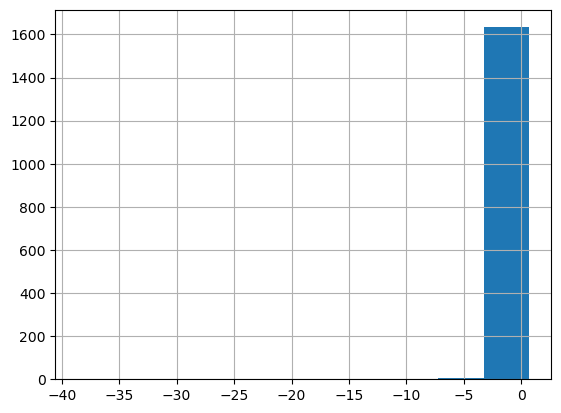

In [158]:
((dose_light_combined["grp_usd_2015"]-dose_light_combined["manufacturing_usd_2015"]-dose_light_combined["services_usd_2015"]-dose_light_combined["agriculture_usd_2015"])/dose_light_combined["grp_usd_2015"]).hist()

## H3 with duckdb

testing the duckdb h3 extension to potentially transfer all the projection on the db side for better performance.

In [159]:
res = conn.raw_sql("""INSTALL h3 FROM community;
                   LOAD h3;""").df()

res

,Success


In [160]:

conn.sql("SELECT h3_cell_to_latlng('822d57fffffffff');")

conn.sql("SELECT h3_cell_to_boundary_wkt('822d57fffffffff');")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ h3_cell_to_boundary_wkt('822d57fffffffff')                                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string                                                                           │
├──────────────────────────────────────────────────────────────────────────────────┤
│ POLYGON ((38.777546 44.198571, 39.938746 42.736298, 42.150674 42.631271, 43.258… │
└──────────────────────────────────────────────────────────────────────────────────┘

In [7]:
! jupyter nbconvert missing_countries.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags rm_cell --to python


[NbConvertApp] Converting notebook missing_countries.ipynb to python
[NbConvertApp] Writing 26855 bytes to missing_countries.py
